🧾 Available columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']

📌 Headline Length Statistics:
count    55987.000000
mean        12.435726
std          8.458581
min          2.000000
25%          7.000000
50%         10.000000
75%         14.000000
max         77.000000
Name: headline_length, dtype: float64


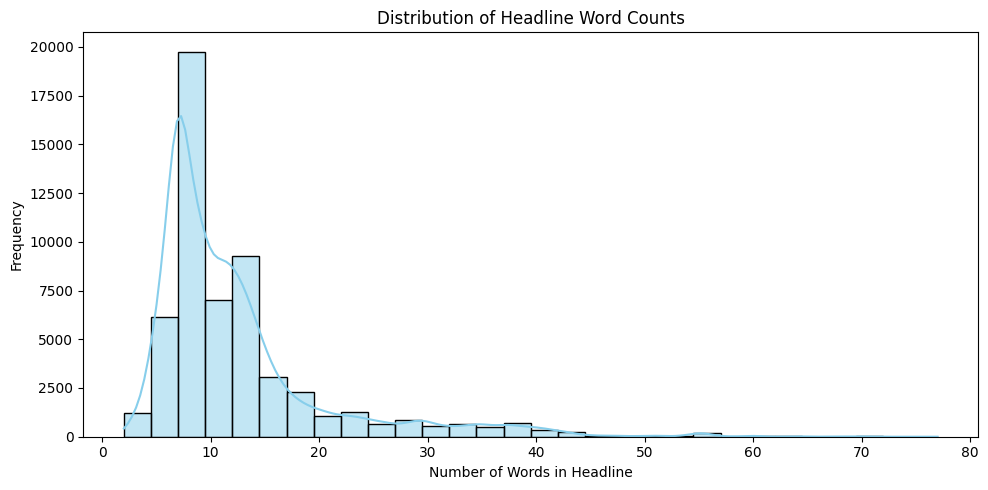


📌 Top Publishers by Article Count:
publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64


C:\Users\Amenzz\AppData\Local\Temp\ipykernel_19724\169208702.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publisher_counts.index[:10], y=publisher_counts.values[:10], palette='viridis')


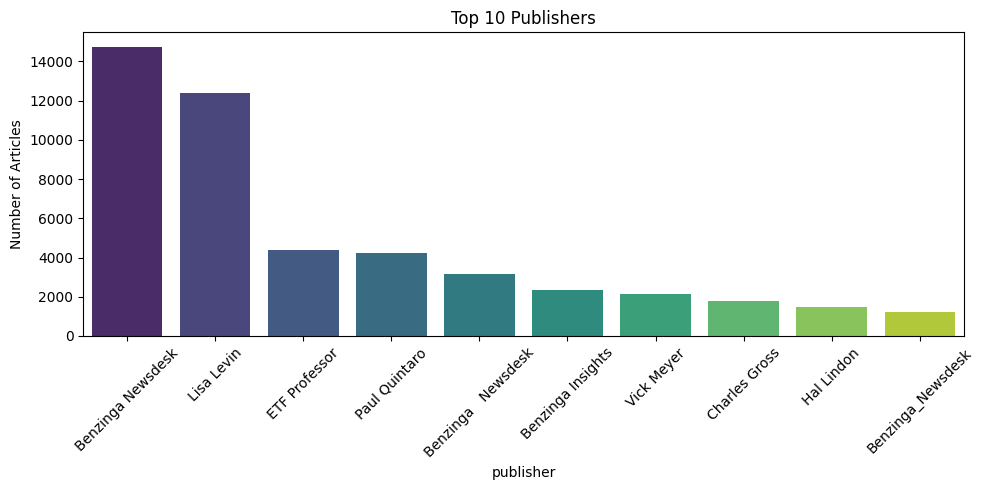

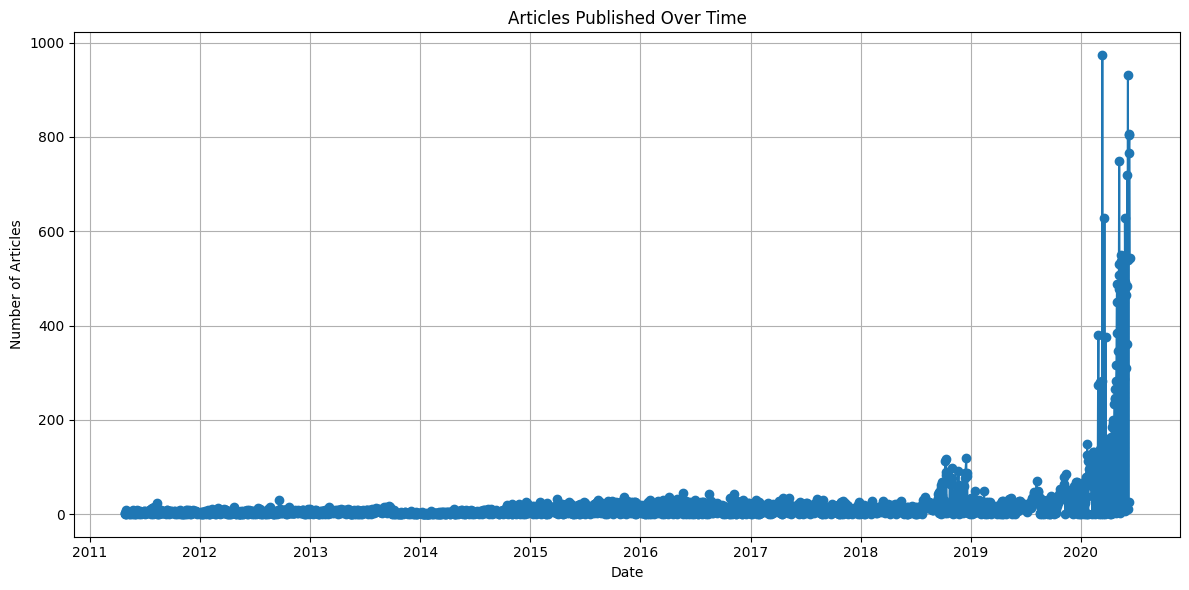


✅ Summary saved to notebooks/output/news_summary_statistics.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ✅ Set correct path to your financial news CSV

file_path = "C:\Users\Amenzz\Desktop\week1\data\raw_analyst_ratings.csv"

# 🔁 Load data
df = pd.read_csv(file_path)

# ✅ Show column names to confirm structure
print("🧾 Available columns:", df.columns.tolist())

# ✅ Check if expected columns exist
required_columns = ['headline', 'publisher', 'date']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: '{col}'")

# ✅ Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# ✅ Drop rows with invalid or missing dates
df = df.dropna(subset=['date'])

# -------------------------------
# 🔹 Headline Length Statistics
# -------------------------------
df['headline_length'] = df['headline'].astype(str).apply(lambda x: len(x.split()))

print("\n📌 Headline Length Statistics:")
print(df['headline_length'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['headline_length'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Headline Word Counts")
plt.xlabel("Number of Words in Headline")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -------------------------------
# 🔹 Top Publishers
# -------------------------------
publisher_counts = df['publisher'].value_counts()

print("\n📌 Top Publishers by Article Count:")
print(publisher_counts.head(10))

plt.figure(figsize=(10, 5))
sns.barplot(x=publisher_counts.index[:10], y=publisher_counts.values[:10], palette='viridis')
plt.title("Top 10 Publishers")
plt.xticks(rotation=45)
plt.ylabel("Number of Articles")
plt.tight_layout()
plt.show()

# -------------------------------
# 🔹 Publication Frequency Over Time
# -------------------------------
daily_counts = df['date'].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 6))
pd.Series(daily_counts).plot(marker='o', linestyle='-')
plt.title("Articles Published Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 🔹 Save Descriptive Statistics
# -------------------------------
output_dir = "notebooks/output"
os.makedirs(output_dir, exist_ok=True)
df.describe(include='all').to_csv(os.path.join(output_dir, "news_summary_statistics.csv"))
print(f"\n✅ Summary saved to {output_dir}/news_summary_statistics.csv")


In [23]:
#Text Analysis(Topic Modeling)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Assuming df is already loaded and cleaned
file_path = "C:\Users\Amenzz\Desktop\week1\data\raw_analyst_ratings.csv"

# 🔁 Load data
df = pd.read_csv(file_path)
# Preprocess headlines: lowercase, remove short words, remove stopwords
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = text.lower().split()
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words and len(t) > 2]
    return " ".join(tokens)

df['clean_headline'] = df['headline'].astype(str).apply(preprocess)
# Use CountVectorizer to find common bigrams/trigrams
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=1000)
X = vectorizer.fit_transform(df['clean_headline'])



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amenzz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Sum counts of each ngram
import numpy as np
counts = np.asarray(X.sum(axis=0)).flatten()
keywords = vectorizer.get_feature_names_out()
keyword_freq = pd.DataFrame({'keyword': keywords, 'count': counts}).sort_values(by='count', ascending=False)

print("Top 20 Keywords/Phrases:")
print(keyword_freq.head(20))


Top 20 Keywords/Phrases:
          keyword   count
851        stocks  159102
248           eps  127403
804        shares  112655
717       reports  108429
483        market   89225
222      earnings   80855
908           top   78354
747         sales   77924
29      announces   66513
641         price   63328
214    downgrades   61862
927       trading   60582
718   reports eps   59119
679        raises   57735
890        target   53530
471     maintains   52958
270           est   49316
555           new   47662
645  price target   46872
96            buy   43697


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
file_path = "C:\Users\Amenzz\Desktop\week1\data\raw_analyst_ratings.csv"

# 🔁 Load data
df = pd.read_csv(file_path)
def print_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic {idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_topics(lda, keywords, 10)


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

df['entities'] = df['headline'].astype(str).apply(extract_entities)

# Example: show some entities found
print(df[['headline', 'entities']].head(10))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
file_path = "C:\Users\Amenzz\Desktop\week1\data\raw_analyst_ratings.csv"
df = pd.read_csv(file_path)

# Convert date column to datetime and drop invalid rows
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# -------------------------------
# Time Series: Daily Publication Counts
# -------------------------------
# Count articles per day
daily_counts = df['date'].dt.date.value_counts().sort_index()

# Calculate 7-day rolling average to smooth data
rolling_counts = daily_counts.rolling(window=7).mean()

plt.figure(figsize=(14, 7))
plt.plot(daily_counts.index, daily_counts.values, label='Daily Articles', marker='o', linestyle='-', alpha=0.6)
plt.plot(rolling_counts.index, rolling_counts.values, label='7-Day Rolling Average', linewidth=3)
plt.title("Daily Article Publications with 7-Day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# Time Series: Hourly Publication Distribution
# -------------------------------
df['hour'] = df['date'].dt.hour

plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=df, color='cornflowerblue')
plt.title("Number of Articles Published by Hour of Day")
plt.xlabel("Hour of Day (24h)")
plt.ylabel("Number of Articles")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# -------------------------------
# Optional: Day of Week Publication Counts
# -------------------------------
df['weekday'] = df['date'].dt.day_name()

plt.figure(figsize=(12, 6))
sns.countplot(
    x='weekday', 
    data=df, 
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    color='salmon'
)
plt.title("Number of Articles Published by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load data (adjust path as needed)
file_path = "C:\Users\Amenzz\Desktop\week1\data\raw_analyst_ratings.csv"
df = pd.read_csv(file_path)

# Clean date
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# -------------------------------
# 1. Top Publishers by Article Count
# -------------------------------
publisher_counts = df['publisher'].value_counts()

print("\n📌 Top 10 Publishers by Article Count:")
print(publisher_counts.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x=publisher_counts.head(10).index, y=publisher_counts.head(10).values, palette='magma')
plt.title("Top 10 Publishers by Number of Articles")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Articles")
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Check if Publisher Looks Like an Email, Extract Domains
# -------------------------------
def extract_domain(publisher):
    # Basic regex to detect email format and extract domain
    if isinstance(publisher, str):
        match = re.search(r'@([A-Za-z0-9.-]+\.[A-Za-z]{2,})$', publisher)
        if match:
            return match.group(1).lower()
    return None

df['publisher_domain'] = df['publisher'].apply(extract_domain)

# Count domain frequencies
domain_counts = df['publisher_domain'].value_counts()

print("\n📌 Top 10 Publisher Domains (if emails present):")
print(domain_counts.head(10))

if domain_counts.empty:
    print("\nNo email-like publisher names detected.")
else:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=domain_counts.head(10).index, y=domain_counts.head(10).values, palette='coolwarm')
    plt.title("Top 10 Publisher Domains by Number of Articles")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Number of Articles")
    plt.tight_layout()
    plt.show()

# -------------------------------
# 3. Simple Analysis: Average Headline Length by Publisher
# -------------------------------
df['headline_length'] = df['headline'].astype(str).apply(lambda x: len(x.split()))

avg_length = df.groupby('publisher')['headline_length'].mean().sort_values(ascending=False).head(10)

print("\n📌 Top 10 Publishers by Average Headline Length:")
print(avg_length)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_length.index, y=avg_length.values, palette='viridis')
plt.title("Top 10 Publishers by Average Headline Length")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Number of Words per Headline")
plt.tight_layout()
plt.show()

# -------------------------------
# 4. Optional: Keyword Differences by Publisher
# (Check if specific keywords appear more frequently in certain publishers' headlines)
# -------------------------------
keyword = 'earnings'  # example keyword to analyze

df['has_keyword'] = df['headline'].str.lower().str.contains(keyword)

keyword_by_publisher = df.groupby('publisher')['has_keyword'].mean().sort_values(ascending=False).head(10)

print(f"\n📌 Top 10 Publishers by Proportion of Headlines Containing '{keyword}':")
print(keyword_by_publisher)

plt.figure(figsize=(12, 6))
sns.barplot(x=keyword_by_publisher.index, y=keyword_by_publisher.values, palette='plasma')
plt.title(f"Top 10 Publishers by Proportion of Headlines Containing '{keyword}'")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Proportion of Headlines")
plt.tight_layout()
plt.show()
